# 🚗 Detección y Seguimiento de Vehículos con YOLO y Flujo Óptico

## 📋 Descripción del Proyecto

Este notebook implementa un sistema completo de visión por computador que integra técnicas avanzadas de detección y seguimiento de objetos para resolver un problema práctico: **el conteo automático de vehículos en videos de tráfico**.

### 🎯 Objetivos del Trabajo

1. **Detección de objetos**: Implementar y configurar un modelo YOLO (v8) para detectar vehículos en cada fotograma
2. **Seguimiento de objetos**: Aplicar técnicas de flujo óptico (Lucas-Kanade) para seguir vehículos entre múltiples fotogramas
3. **Integración**: Construir un pipeline coherente que integre ambas técnicas
4. **Aplicación práctica**: Contar vehículos que cruzan una línea virtual en una intersección
5. **Evaluación**: Evaluar cuantitativamente el desempeño del sistema con métricas claras

### 🔧 Tecnologías Utilizadas

- **YOLO v8**: Modelo de detección de objetos en tiempo real, pre-entrenado en el dataset COCO
- **Flujo Óptico Lucas-Kanade**: Algoritmo clásico de visión por computador para seguimiento de objetos
- **OpenCV**: Librería para procesamiento de imágenes y video
- **Python**: Lenguaje de programación principal

### 📊 Estructura del Notebook

1. **Configuración inicial**: Importación de librerías y configuración del entorno
2. **Arquitectura del sistema**: Definición de clases y estructuras de datos
3. **Detección con YOLO**: Implementación del módulo de detección
4. **Seguimiento con flujo óptico**: Implementación del módulo de seguimiento
5. **Conteo de vehículos**: Lógica para detectar cruces de línea virtual
6. **Pipeline completo**: Integración de todos los componentes
7. **Evaluación y visualización**: Análisis de resultados y métricas de rendimiento
8. **Resultados**: Visualización de outputs y conclusiones

---

## 🚀 Inicio: Configuración del Entorno


### 📦 Importación de Librerías

En esta celda importamos todas las dependencias necesarias para el proyecto:

- **cv2 (OpenCV)**: Procesamiento de imágenes, video y algoritmos de visión por computador
- **numpy**: Operaciones numéricas y arrays multidimensionales
- **matplotlib**: Visualización de datos y gráficas
- **ultralytics**: Implementación de YOLO v8
- **pathlib**: Manejo de rutas de archivos de forma multiplataforma
- **dataclasses**: Estructuras de datos con sintaxis simplificada

In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pathlib import Path
from typing import List, Tuple, Dict
import json
import time
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

# Para YOLO
try:
    from ultralytics import YOLO
    YOLO_AVAILABLE = True
except ImportError:
    print("⚠️  ultralytics no está instalado. Instalando...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'ultralytics'])
    from ultralytics import YOLO
    YOLO_AVAILABLE = True

# Configuración de visualización
plt.style.use('default')
%matplotlib inline

# Configuración de rutas
BASE_DIR = Path('../')
DATA_DIR = BASE_DIR / 'data'
RESULTS_DIR = BASE_DIR / 'results'
RESULTS_DIR.mkdir(exist_ok=True)

print("✅ Librerías importadas correctamente")


✅ Librerías importadas correctamente


## 1. Arquitectura del Sistema: Clases y Estructuras de Datos

### 📐 Diseño de la Arquitectura

El sistema está diseñado con una arquitectura orientada a objetos que separa claramente las responsabilidades:

1. **`Detection`**: Almacena información de una detección individual (bounding box, confianza, clase)
2. **`TrackedObject`**: Mantiene el historial de un objeto seguido a lo largo del tiempo
3. **`VehicleTracker`**: Clase principal que orquesta detección, seguimiento y conteo

### 🔍 Explicación Técnica

- **Bounding Box (bbox)**: Rectángulo que delimita el objeto detectado (coordenadas x1, y1, x2, y2)
- **Confidence**: Nivel de confianza de la detección (0.0 a 1.0)
- **Trajectory**: Historial de posiciones del centro del objeto a lo largo de los frames
- **Flujo Óptico**: Técnica que calcula el movimiento de puntos entre frames consecutivos


In [40]:
# ============================================================================
# DEFINICIÓN DE CLASES Y ESTRUCTURAS DE DATOS
# ============================================================================

@dataclass
class Detection:
    """
    Almacena información de una detección individual de YOLO.
    
    Atributos:
        bbox: Coordenadas del bounding box (x1, y1, x2, y2)
        confidence: Nivel de confianza de la detección (0.0 a 1.0)
        class_id: ID numérico de la clase según COCO dataset
        class_name: Nombre de la clase (ej: 'car', 'truck', 'bus')
        center: Coordenadas del centro del bounding box (x, y)
    """
    bbox: Tuple[int, int, int, int]  # x1, y1, x2, y2
    confidence: float
    class_id: int
    class_name: str
    center: Tuple[int, int]  # Centro del bounding box calculado como ((x1+x2)/2, (y1+y2)/2)
    
@dataclass
class TrackedObject:
    """Clase para almacenar información de un objeto seguido"""
    object_id: int
    detections: List[Detection]
    trajectory: List[Tuple[int, int]]  # Historial de posiciones del centro
    last_seen: int  # Último frame donde fue visto
    crossed_line: bool  # Si ya cruzó la línea virtual
    
class VehicleTracker:
    """Clase principal para detección y seguimiento de vehículos"""
    
    def __init__(self, yolo_model='yolov8n.pt', conf_threshold=0.25, 
                 iou_threshold=0.45, vehicle_classes=[2, 3, 5, 7]):
        """
        Args:
            yolo_model: Modelo YOLO a usar ('yolov8n.pt', 'yolov8s.pt', etc.)
            conf_threshold: Umbral de confianza para detecciones
            iou_threshold: Umbral de IoU para NMS
            vehicle_classes: IDs de clases de vehículos en COCO (2=car, 3=motorcycle, 5=bus, 7=truck)
        """
        self.model = YOLO(yolo_model)
        self.conf_threshold = conf_threshold
        self.iou_threshold = iou_threshold
        self.vehicle_classes = vehicle_classes
        
        # Para seguimiento
        self.next_id = 0
        self.tracked_objects: Dict[int, TrackedObject] = {}
        self.max_disappeared = 10  # Frames sin ver antes de eliminar
        
        # Para flujo óptico
        self.lk_params = dict(winSize=(15, 15),
                             maxLevel=2,
                             criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
        
        # Para conteo
        self.count_line = None  # Línea virtual para conteo (x1, y1, x2, y2)
        self.vehicle_count = 0
        self.count_history = []
        
        print(f"✅ Tracker inicializado con modelo: {yolo_model}")

print("✅ Clases y estructuras de datos definidas")


✅ Clases y estructuras de datos definidas


### 📊 Visualización de la Estructura de Datos

A continuación mostramos un ejemplo de cómo se estructura la información en nuestro sistema:


EJEMPLO DE ESTRUCTURA DE DATOS

📦 Ejemplo de Detection:
   Bounding Box: (100, 150, 300, 400)
   Confianza: 87.00%
   Clase: car (ID: 2)
   Centro: (200, 275)


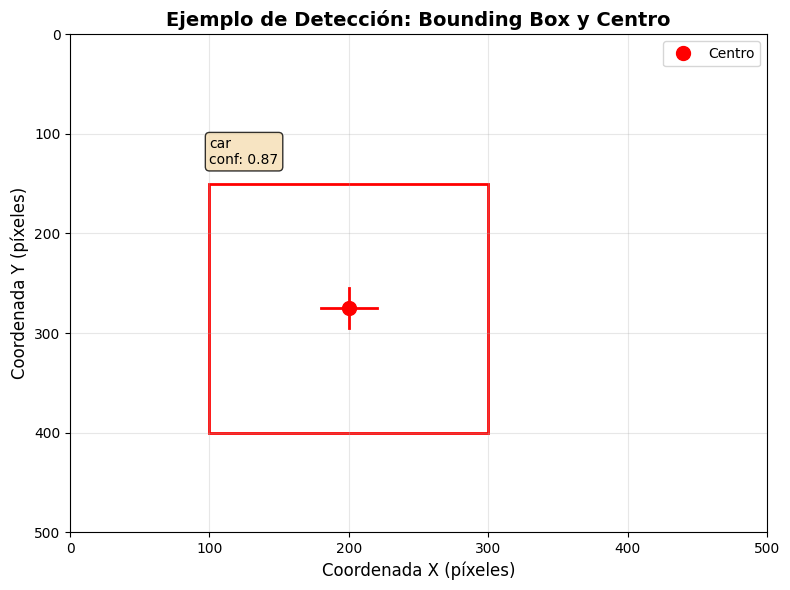


✅ Estructura de datos definida y visualizada
   Imagen guardada en: ../results/ejemplo_deteccion.png


In [41]:
# Ejemplo de estructura de datos (para documentación)
print("=" * 60)
print("EJEMPLO DE ESTRUCTURA DE DATOS")
print("=" * 60)

# Ejemplo de Detection
ejemplo_detection = Detection(
    bbox=(100, 150, 300, 400),
    confidence=0.87,
    class_id=2,
    class_name="car",
    center=(200, 275)
)

print("\n📦 Ejemplo de Detection:")
print(f"   Bounding Box: {ejemplo_detection.bbox}")
print(f"   Confianza: {ejemplo_detection.confidence:.2%}")
print(f"   Clase: {ejemplo_detection.class_name} (ID: {ejemplo_detection.class_id})")
print(f"   Centro: {ejemplo_detection.center}")

# Visualización esquemática
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_xlim(0, 500)
ax.set_ylim(0, 500)
ax.invert_yaxis()

# Dibujar bounding box
x1, y1, x2, y2 = ejemplo_detection.bbox
rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                     linewidth=2, edgecolor='red', facecolor='none')
ax.add_patch(rect)

# Dibujar centro
cx, cy = ejemplo_detection.center
ax.plot(cx, cy, 'ro', markersize=10, label='Centro')
ax.plot([cx-20, cx+20], [cy, cy], 'r-', linewidth=2)
ax.plot([cx, cx], [cy-20, cy+20], 'r-', linewidth=2)

ax.set_title('Ejemplo de Detección: Bounding Box y Centro', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Coordenada X (píxeles)', fontsize=12)
ax.set_ylabel('Coordenada Y (píxeles)', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)
ax.text(x1, y1-20, f'{ejemplo_detection.class_name}\nconf: {ejemplo_detection.confidence:.2f}',
        fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'ejemplo_deteccion.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Estructura de datos definida y visualizada")
print(f"   Imagen guardada en: {RESULTS_DIR / 'ejemplo_deteccion.png'}")


## 2. Detección de Objetos con YOLO v8

### 🎯 ¿Qué es YOLO?

**YOLO (You Only Look Once)** es un algoritmo de detección de objetos en tiempo real que procesa imágenes completas en una sola pasada de red neuronal, a diferencia de métodos tradicionales que usan ventanas deslizantes.

### 🔧 Características del Modelo YOLO v8

- **Velocidad**: Procesa videos en tiempo real (30+ FPS en hardware moderno)
- **Precisión**: Modelo pre-entrenado en COCO dataset con 80 clases de objetos
- **Clases de vehículos detectadas**:
  - `class_id=2`: Car (automóvil)
  - `class_id=3`: Motorcycle (motocicleta)
  - `class_id=5`: Bus (autobús)
  - `class_id=7`: Truck (camión)

### 📊 Parámetros de Configuración

- **conf_threshold (0.25)**: Umbral mínimo de confianza para aceptar una detección
- **iou_threshold (0.45)**: Umbral para Non-Maximum Suppression (elimina detecciones duplicadas)

### 🔄 Proceso de Detección

1. El modelo YOLO procesa cada frame del video
2. Genera múltiples detecciones con bounding boxes y niveles de confianza
3. Filtramos solo las detecciones de vehículos (clases 2, 3, 5, 7)
4. Aplicamos NMS para eliminar duplicados
5. Retornamos lista de detecciones válidas

In [42]:
# Agregar métodos a VehicleTracker
def detect_vehicles(self, frame):
    """
    Detecta vehículos en un frame usando YOLO
    
    Args:
        frame: Frame de video (numpy array BGR)
    
    Returns:
        List[Detection]: Lista de detecciones de vehículos
    """
    results = self.model(frame, conf=self.conf_threshold, iou=self.iou_threshold, verbose=False)
    detections = []
    
    for result in results:
        boxes = result.boxes
        for box in boxes:
            class_id = int(box.cls[0])
            if class_id in self.vehicle_classes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                confidence = float(box.conf[0])
                class_name = self.model.names[class_id]
                center = ((x1 + x2) // 2, (y1 + y2) // 2)
                
                detections.append(Detection(
                    bbox=(x1, y1, x2, y2),
                    confidence=confidence,
                    class_id=class_id,
                    class_name=class_name,
                    center=center
                ))
    
    return detections

VehicleTracker.detect_vehicles = detect_vehicles

print("✅ Método de detección implementado")


✅ Método de detección implementado


🔍 Demostración de Detección con YOLO
✅ Tracker inicializado con modelo: yolov8n.pt


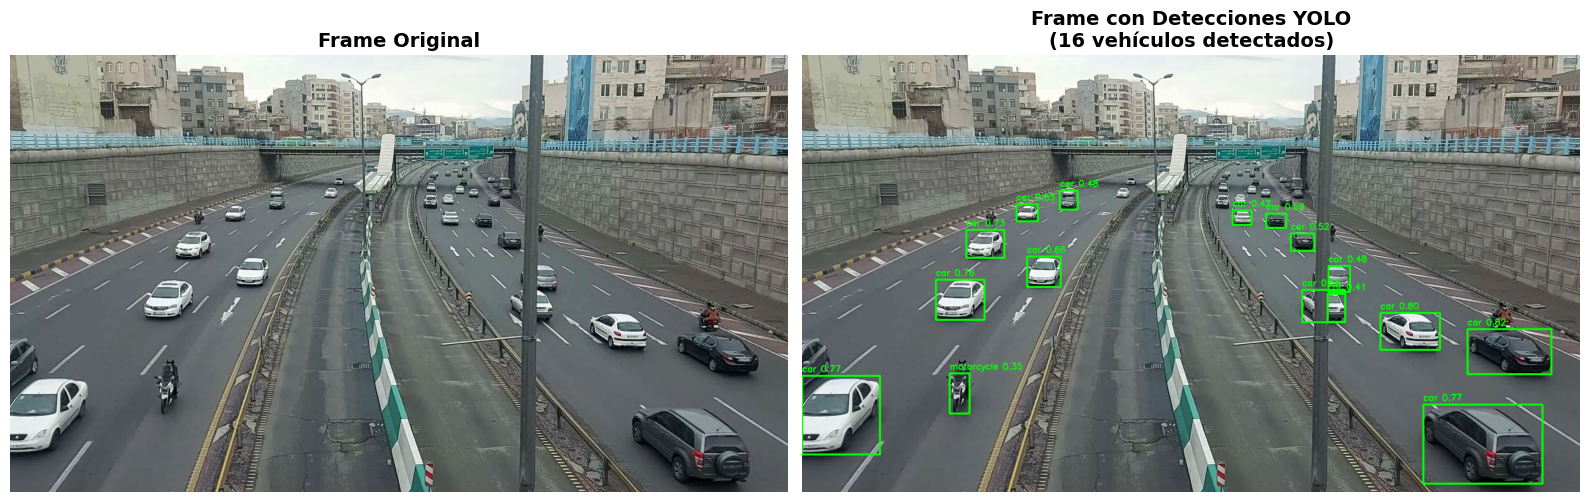


📊 Estadísticas de Detección:
   Total de vehículos detectados: 16
   Distribución por clase:
      - car: 15
      - motorcycle: 1
   Confianza promedio: 0.602
   Confianza mínima: 0.345
   Confianza máxima: 0.821

✅ Imagen guardada en: ../results/ejemplo_deteccion_yolo.png


In [43]:
# Demostración de detección en un frame de ejemplo
print("🔍 Demostración de Detección con YOLO")
print("=" * 60)

# Verificar que el método detect_vehicles esté disponible
if not hasattr(VehicleTracker, 'detect_vehicles'):
    print("⚠️  El método detect_vehicles aún no está definido.")
    print("   Por favor, ejecuta primero la celda que define el método detect_vehicles")
    print("   (celda con 'Agregar métodos a VehicleTracker')")
else:
    # Buscar un video para extraer un frame de ejemplo
    video_files = list(DATA_DIR.glob('*.mp4'))
    if video_files:
        cap = cv2.VideoCapture(str(video_files[0]))
        ret, sample_frame = cap.read()
        cap.release()
        
        if ret:
            # Inicializar tracker temporal para demo
            demo_tracker = VehicleTracker(yolo_model='yolov8n.pt', conf_threshold=0.25)
            
            # Detectar vehículos
            detections = demo_tracker.detect_vehicles(sample_frame)
            
            # Dibujar detecciones
            frame_annotated = sample_frame.copy()
            for det in detections:
                x1, y1, x2, y2 = det.bbox
                cv2.rectangle(frame_annotated, (x1, y1), (x2, y2), (0, 255, 0), 3)
                label = f"{det.class_name} {det.confidence:.2f}"
                cv2.putText(frame_annotated, label, (x1, y1 - 10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            
            # Convertir BGR a RGB para matplotlib
            frame_rgb = cv2.cvtColor(frame_annotated, cv2.COLOR_BGR2RGB)
            
            # Visualizar
            fig, axes = plt.subplots(1, 2, figsize=(16, 8))
            
            # Frame original
            axes[0].imshow(cv2.cvtColor(sample_frame, cv2.COLOR_BGR2RGB))
            axes[0].set_title('Frame Original', fontsize=14, fontweight='bold')
            axes[0].axis('off')
            
            # Frame con detecciones
            axes[1].imshow(frame_rgb)
            axes[1].set_title(f'Frame con Detecciones YOLO\n({len(detections)} vehículos detectados)', 
                              fontsize=14, fontweight='bold')
            axes[1].axis('off')
            
            plt.tight_layout()
            plt.savefig(RESULTS_DIR / 'ejemplo_deteccion_yolo.png', dpi=150, bbox_inches='tight')
            plt.show()
            
            # Mostrar estadísticas
            print(f"\n📊 Estadísticas de Detección:")
            print(f"   Total de vehículos detectados: {len(detections)}")
            if detections:
                class_counts = {}
                confidences = []
                for det in detections:
                    class_counts[det.class_name] = class_counts.get(det.class_name, 0) + 1
                    confidences.append(det.confidence)
                
                print(f"   Distribución por clase:")
                for clase, count in class_counts.items():
                    print(f"      - {clase}: {count}")
                print(f"   Confianza promedio: {np.mean(confidences):.3f}")
                print(f"   Confianza mínima: {np.min(confidences):.3f}")
                print(f"   Confianza máxima: {np.max(confidences):.3f}")
            
            print(f"\n✅ Imagen guardada en: {RESULTS_DIR / 'ejemplo_deteccion_yolo.png'}")
        else:
            print("⚠️  No se pudo leer el video para la demostración")
    else:
        print("⚠️  No se encontraron videos para la demostración")


In [44]:
# Visualización del concepto de IoU (Intersection over Union)
print("📐 Explicación Visual: Intersection over Union (IoU)")
print("=" * 60)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Ejemplo 1: Alta superposición (IoU alto)
bbox1 = (100, 100, 200, 200)
bbox2 = (110, 110, 210, 210)
iou1 = calculate_iou(bbox1, bbox2)

ax = axes[0]
rect1 = plt.Rectangle((bbox1[0], bbox1[1]), bbox1[2]-bbox1[0], bbox1[3]-bbox1[1],
                     linewidth=3, edgecolor='blue', facecolor='lightblue', alpha=0.5, label='BBox 1')
rect2 = plt.Rectangle((bbox2[0], bbox2[1]), bbox2[2]-bbox2[0], bbox2[3]-bbox2[1],
                     linewidth=3, edgecolor='red', facecolor='lightcoral', alpha=0.5, label='BBox 2')
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.set_xlim(80, 230)
ax.set_ylim(80, 230)
ax.invert_yaxis()
ax.set_title(f'IoU Alto = {iou1:.3f}\n(Mismo objeto probable)', 
             fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Ejemplo 2: Baja superposición (IoU bajo)
bbox3 = (100, 100, 200, 200)
bbox4 = (250, 250, 350, 350)
iou2 = calculate_iou(bbox3, bbox4)

ax = axes[1]
rect3 = plt.Rectangle((bbox3[0], bbox3[1]), bbox3[2]-bbox3[0], bbox3[3]-bbox3[1],
                     linewidth=3, edgecolor='blue', facecolor='lightblue', alpha=0.5, label='BBox 1')
rect4 = plt.Rectangle((bbox4[0], bbox4[1]), bbox4[2]-bbox4[0], bbox4[3]-bbox4[1],
                     linewidth=3, edgecolor='red', facecolor='lightcoral', alpha=0.5, label='BBox 2')
ax.add_patch(rect3)
ax.add_patch(rect4)
ax.set_xlim(80, 370)
ax.set_ylim(80, 370)
ax.invert_yaxis()
ax.set_title(f'IoU Bajo = {iou2:.3f}\n(Objetos diferentes)', 
             fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Explicación de la fórmula
ax = axes[2]
ax.axis('off')
formula_text = """
FÓRMULA IoU:

    IoU = Área de Intersección / Área de Unión

Donde:
• Intersección = área común entre ambos bboxes
• Unión = área total cubierta por ambos bboxes

Umbral usado: 0.3
• IoU > 0.3 → Mismo objeto
• IoU ≤ 0.3 → Objetos diferentes
"""
ax.text(0.1, 0.5, formula_text, fontsize=12, 
        verticalalignment='center',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'explicacion_iou.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Visualización guardada en: {RESULTS_DIR / 'explicacion_iou.png'}")


📐 Explicación Visual: Intersection over Union (IoU)


✅ Visualización guardada en: ../results/explicacion_iou.png


📏 Visualización: Línea Virtual de Conteo


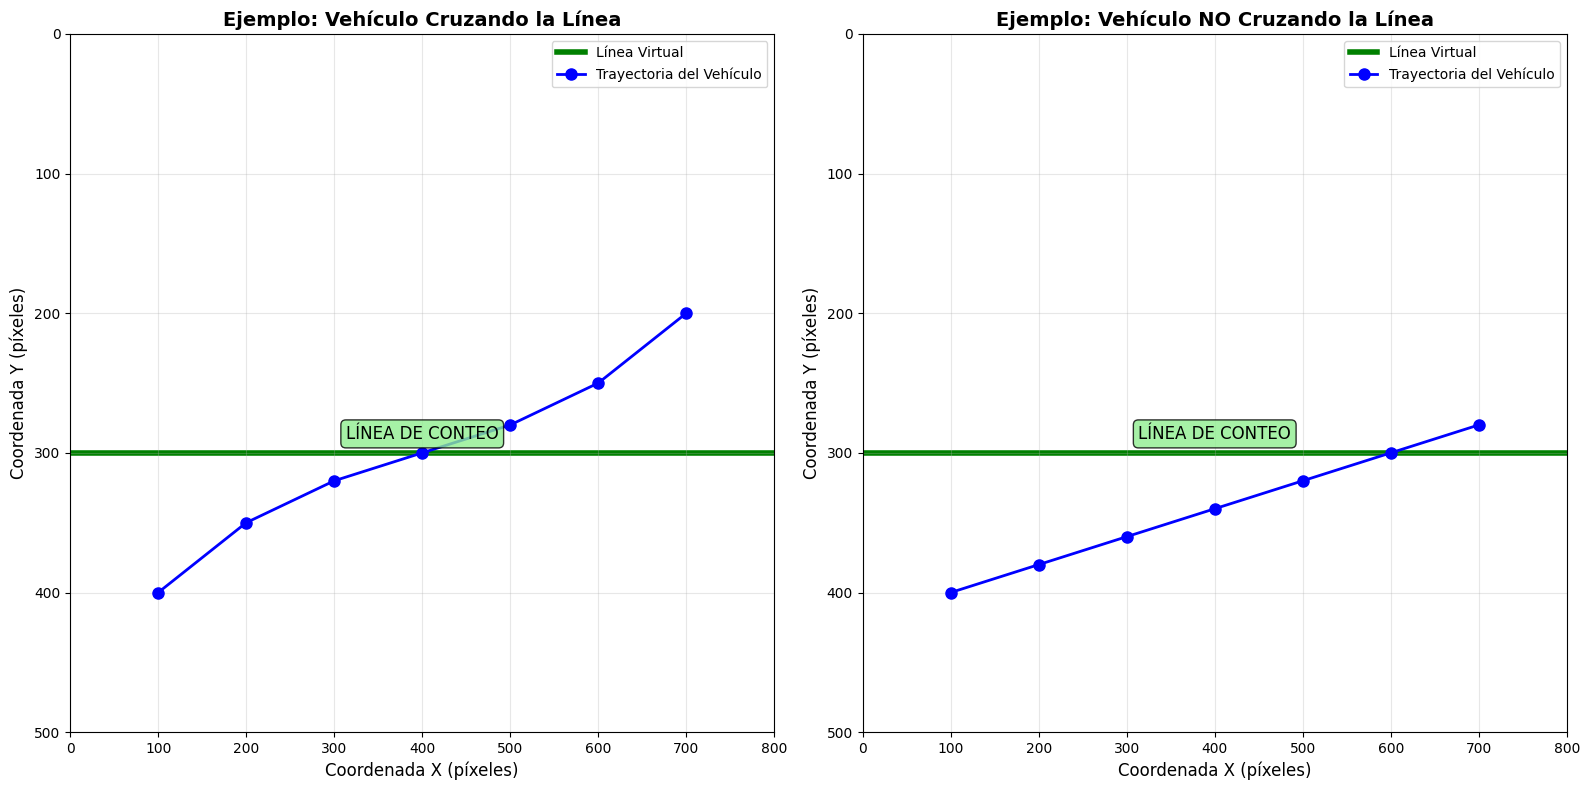

✅ Visualización guardada en: ../results/explicacion_linea_virtual.png

💡 Nota: El algoritmo detecta el cambio de signo en la ecuación de la línea
   cuando la trayectoria del vehículo cruza de un lado al otro.


In [45]:
# Visualización del concepto de línea virtual y detección de cruce
print("📏 Visualización: Línea Virtual de Conteo")
print("=" * 60)

# Función auxiliar para verificar cruce de línea (versión independiente para visualización)
def check_line_crossing_helper(point1, point2, line):
    """
    Verifica si un segmento cruza la línea virtual (función auxiliar para visualización)
    
    Args:
        point1: Punto anterior (x, y)
        point2: Punto actual (x, y)
        line: Línea virtual (x1, y1, x2, y2)
    
    Returns:
        bool: True si cruza la línea
    """
    x1, y1, x2, y2 = line
    px1, py1 = point1
    px2, py2 = point2
    
    # Ecuación de la línea: ax + by + c = 0
    a = y2 - y1
    b = x1 - x2
    c = x2 * y1 - x1 * y2
    
    # Evaluar puntos en la ecuación
    d1 = a * px1 + b * py1 + c
    d2 = a * px2 + b * py2 + c
    
    # Si tienen signos diferentes, cruza la línea
    if d1 * d2 < 0:
        # Verificar que el cruce está dentro del segmento de la línea
        # Calcular intersección
        denom = (px2 - px1) * (y2 - y1) - (py2 - py1) * (x2 - x1)
        if abs(denom) > 1e-6:
            t = ((x1 - px1) * (y2 - y1) - (y1 - py1) * (x2 - x1)) / denom
            if 0 <= t <= 1:
                return True
    return False

# Crear un ejemplo visual
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Ejemplo 1: Trayectoria que cruza la línea
ax = axes[0]
line = (0, 300, 800, 300)  # Línea horizontal
trajectory = [(100, 400), (200, 350), (300, 320), (400, 300), (500, 280), (600, 250), (700, 200)]

# Dibujar línea
x1, y1, x2, y2 = line
ax.plot([x1, x2], [y1, y2], 'g-', linewidth=4, label='Línea Virtual', zorder=1)
ax.text(400, 290, 'LÍNEA DE CONTEO', fontsize=12, ha='center', 
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

# Dibujar trayectoria
traj_x = [p[0] for p in trajectory]
traj_y = [p[1] for p in trajectory]
ax.plot(traj_x, traj_y, 'b-o', linewidth=2, markersize=8, label='Trayectoria del Vehículo', zorder=2)

# Marcar punto de cruce
for i in range(len(trajectory)-1):
    if check_line_crossing_helper(trajectory[i], trajectory[i+1], line):
        ax.plot(trajectory[i+1][0], trajectory[i+1][1], 'r*', markersize=20, 
               label='Punto de Cruce Detectado', zorder=3)
        break

ax.set_xlim(0, 800)
ax.set_ylim(0, 500)
ax.invert_yaxis()
ax.set_title('Ejemplo: Vehículo Cruzando la Línea', fontsize=14, fontweight='bold')
ax.set_xlabel('Coordenada X (píxeles)', fontsize=12)
ax.set_ylabel('Coordenada Y (píxeles)', fontsize=12)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Ejemplo 2: Trayectoria que NO cruza la línea
ax = axes[1]
trajectory2 = [(100, 400), (200, 380), (300, 360), (400, 340), (500, 320), (600, 300), (700, 280)]

# Dibujar línea
ax.plot([x1, x2], [y1, y2], 'g-', linewidth=4, label='Línea Virtual', zorder=1)
ax.text(400, 290, 'LÍNEA DE CONTEO', fontsize=12, ha='center',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

# Dibujar trayectoria
traj_x2 = [p[0] for p in trajectory2]
traj_y2 = [p[1] for p in trajectory2]
ax.plot(traj_x2, traj_y2, 'b-o', linewidth=2, markersize=8, label='Trayectoria del Vehículo', zorder=2)

ax.set_xlim(0, 800)
ax.set_ylim(0, 500)
ax.invert_yaxis()
ax.set_title('Ejemplo: Vehículo NO Cruzando la Línea', fontsize=14, fontweight='bold')
ax.set_xlabel('Coordenada X (píxeles)', fontsize=12)
ax.set_ylabel('Coordenada Y (píxeles)', fontsize=12)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'explicacion_linea_virtual.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Visualización guardada en: {RESULTS_DIR / 'explicacion_linea_virtual.png'}")
print("\n💡 Nota: El algoritmo detecta el cambio de signo en la ecuación de la línea")
print("   cuando la trayectoria del vehículo cruza de un lado al otro.")


## 3. Métodos de Seguimiento con Flujo Óptico

In [47]:
# Diagrama de flujo del pipeline
print("🔄 Diagrama del Pipeline de Procesamiento")
print("=" * 60)

fig, ax = plt.subplots(1, 1, figsize=(14, 10))
ax.axis('off')

# Definir posiciones de los componentes
components = {
    'Video Input': (2, 9),
    'Read Frame': (2, 8),
    'YOLO Detection': (2, 6.5),
    'Association (IoU)': (5, 6.5),
    'Optical Flow': (5, 5),
    'Update Trajectories': (5, 3.5),
    'Line Crossing Check': (8, 4.5),
    'Visualization': (8, 3),
    'Output Video': (8, 1.5)
}

# Dibujar componentes
for name, (x, y) in components.items():
    if 'Input' in name or 'Output' in name:
        color = 'lightblue'
        width, height = 1.2, 0.6
    elif 'Detection' in name:
        color = 'lightgreen'
        width, height = 1.5, 0.6
    elif 'Flow' in name:
        color = 'lightyellow'
        width, height = 1.5, 0.6
    else:
        color = 'lightcoral'
        width, height = 1.2, 0.6
    
    rect = plt.Rectangle((x-width/2, y-height/2), width, height,
                        facecolor=color, edgecolor='black', linewidth=2)
    ax.add_patch(rect)
    ax.text(x, y, name, ha='center', va='center', fontsize=10, fontweight='bold')

# Dibujar flechas
arrows = [
    ((2, 8.7), (2, 8.3)),
    ((2, 7.7), (2, 7.3)),
    ((2, 6.2), (3.5, 6.5)),
    ((3.5, 6.5), (5, 6.5)),
    ((5, 6.2), (5, 5.3)),
    ((5, 4.7), (5, 3.8)),
    ((6.5, 4.5), (8, 4.5)),
    ((8, 4.2), (8, 3.3)),
    ((8, 2.7), (8, 1.8))
]

for (x1, y1), (x2, y2) in arrows:
    ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
               arrowprops=dict(arrowstyle='->', lw=2, color='black'))

# Título
ax.text(5, 9.8, 'PIPELINE DE PROCESAMIENTO DE VIDEO', 
       ha='center', fontsize=16, fontweight='bold',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Leyenda
legend_text = """
Leyenda:
🟦 Entrada/Salida
🟩 Detección YOLO
🟨 Flujo Óptico
🟥 Procesamiento
"""
ax.text(0.5, 2, legend_text, fontsize=10,
       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.set_xlim(0, 10)
ax.set_ylim(0, 10)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'diagrama_pipeline.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Diagrama guardado en: {RESULTS_DIR / 'diagrama_pipeline.png'}")


🔄 Diagrama del Pipeline de Procesamiento


✅ Diagrama guardado en: ../results/diagrama_pipeline.png


In [48]:
def calculate_iou(bbox1, bbox2):
    """Calcula Intersection over Union (IoU) entre dos bounding boxes"""
    x1_1, y1_1, x2_1, y2_1 = bbox1
    x1_2, y1_2, x2_2, y2_2 = bbox2
    
    # Calcular intersección
    x1_i = max(x1_1, x1_2)
    y1_i = max(y1_1, y1_2)
    x2_i = min(x2_1, x2_2)
    y2_i = min(y2_1, y2_2)
    
    if x2_i < x1_i or y2_i < y1_i:
        return 0.0
    
    intersection = (x2_i - x1_i) * (y2_i - y1_i)
    area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
    area2 = (x2_2 - x1_2) * (y2_2 - y1_2)
    union = area1 + area2 - intersection
    
    return intersection / union if union > 0 else 0.0

def track_with_optical_flow(self, prev_frame, curr_frame, prev_gray, curr_gray, 
                            detections, frame_number):
    """
    Realiza seguimiento de objetos usando flujo óptico Lucas-Kanade
    
    Args:
        prev_frame: Frame anterior
        curr_frame: Frame actual
        prev_gray: Frame anterior en escala de grises
        curr_gray: Frame actual en escala de grises
        detections: Lista de detecciones actuales
        frame_number: Número del frame actual
    
    Returns:
        frame_annotated: Frame con anotaciones de seguimiento
    """
    # Actualizar objetos existentes con flujo óptico
    objects_to_remove = []
    
    for obj_id, tracked_obj in self.tracked_objects.items():
        if len(tracked_obj.trajectory) == 0:
            continue
            
        # Obtener último punto de seguimiento
        last_point = np.array(tracked_obj.trajectory[-1], dtype=np.float32).reshape(-1, 1, 2)
        
        # Calcular flujo óptico
        next_points, status, error = cv2.calcOpticalFlowPyrLK(
            prev_gray, curr_gray, last_point, None, **self.lk_params
        )
        
        if status[0][0] == 1:  # Punto válido
            new_point = tuple(next_points[0][0].astype(int))
            tracked_obj.trajectory.append(new_point)
            tracked_obj.last_seen = frame_number
        else:
            # Punto perdido, incrementar contador
            if frame_number - tracked_obj.last_seen > self.max_disappeared:
                objects_to_remove.append(obj_id)
    
    # Eliminar objetos perdidos
    for obj_id in objects_to_remove:
        del self.tracked_objects[obj_id]
    
    # Asociar nuevas detecciones con objetos existentes
    used_detections = set()
    iou_threshold = 0.3
    
    for obj_id, tracked_obj in self.tracked_objects.items():
        if len(tracked_obj.detections) == 0:
            continue
            
        last_detection = tracked_obj.detections[-1]
        best_iou = 0
        best_detection_idx = -1
        
        for idx, detection in enumerate(detections):
            if idx in used_detections:
                continue
                
            iou = calculate_iou(last_detection.bbox, detection.bbox)
            if iou > best_iou and iou > iou_threshold:
                best_iou = iou
                best_detection_idx = idx
        
        if best_detection_idx >= 0:
            detection = detections[best_detection_idx]
            tracked_obj.detections.append(detection)
            tracked_obj.trajectory.append(detection.center)
            tracked_obj.last_seen = frame_number
            used_detections.add(best_detection_idx)
    
    # Crear nuevos objetos para detecciones no asociadas
    for idx, detection in enumerate(detections):
        if idx not in used_detections:
            new_obj = TrackedObject(
                object_id=self.next_id,
                detections=[detection],
                trajectory=[detection.center],
                last_seen=frame_number,
                crossed_line=False
            )
            self.tracked_objects[self.next_id] = new_obj
            self.next_id += 1
    
    # Dibujar resultados en el frame
    frame_annotated = curr_frame.copy()
    
    for obj_id, tracked_obj in self.tracked_objects.items():
        if len(tracked_obj.detections) == 0:
            continue
            
        detection = tracked_obj.detections[-1]
        x1, y1, x2, y2 = detection.bbox
        
        # Color según ID
        color = self._get_color(obj_id)
        
        # Dibujar bounding box
        cv2.rectangle(frame_annotated, (x1, y1), (x2, y2), color, 2)
        
        # Etiqueta con ID y clase
        label = f"ID:{obj_id} {detection.class_name} {detection.confidence:.2f}"
        cv2.putText(frame_annotated, label, (x1, y1 - 10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        # Dibujar trayectoria
        if len(tracked_obj.trajectory) > 1:
            points = np.array(tracked_obj.trajectory, dtype=np.int32)
            cv2.polylines(frame_annotated, [points], False, color, 2)
    
    return frame_annotated

def _get_color(self, obj_id):
    """Genera un color único para cada ID"""
    np.random.seed(obj_id)
    color = tuple(map(int, np.random.randint(0, 255, 3)))
    return color

VehicleTracker.track_with_optical_flow = track_with_optical_flow
VehicleTracker._get_color = _get_color

print("✅ Métodos de seguimiento con flujo óptico implementados")


✅ Métodos de seguimiento con flujo óptico implementados


## 4. Métodos de Conteo de Vehículos

In [50]:
# Mostrar información del video antes de procesar
print("📹 Información del Video de Entrada")
print("=" * 60)

video_files = list(DATA_DIR.glob('*.mp4'))
if video_files:
    video_path = DATA_DIR / 'SampleVideo_LowQuality.mp4' if (DATA_DIR / 'SampleVideo_LowQuality.mp4').exists() else video_files[0]
    
    cap = cv2.VideoCapture(str(video_path))
    if cap.isOpened():
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        duration = total_frames / fps if fps > 0 else 0
        
        # Leer primer frame para visualización
        ret, first_frame = cap.read()
        cap.release()
        
        if ret:
            print(f"   Archivo: {video_path.name}")
            print(f"   Resolución: {width} x {height} píxeles")
            print(f"   FPS: {fps}")
            print(f"   Total de frames: {total_frames}")
            print(f"   Duración aproximada: {duration:.2f} segundos")
            print(f"   Tamaño del archivo: {video_path.stat().st_size / (1024*1024):.2f} MB")
            
            # Visualizar primer frame
            fig, ax = plt.subplots(1, 1, figsize=(12, 8))
            ax.imshow(cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB))
            ax.set_title(f'Primer Frame del Video\n{video_path.name}', 
                        fontsize=14, fontweight='bold')
            ax.axis('off')
            
            # Agregar información como texto
            info_text = f"Resolución: {width}x{height}\nFPS: {fps}\nFrames: {total_frames}"
            ax.text(10, 30, info_text, fontsize=12, color='white',
                   bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
            
            plt.tight_layout()
            plt.savefig(RESULTS_DIR / 'video_info.png', dpi=150, bbox_inches='tight')
            plt.show()
            
            print(f"\n✅ Información del video visualizada")
            print(f"   Imagen guardada en: {RESULTS_DIR / 'video_info.png'}")
        else:
            print("⚠️  No se pudo leer el primer frame")
    else:
        print("⚠️  No se pudo abrir el video")
else:
    print("⚠️  No se encontraron videos")


📹 Información del Video de Entrada
   Archivo: SampleVideo_LowQuality.mp4
   Resolución: 1920 x 1080 píxeles
   FPS: 24
   Total de frames: 1001
   Duración aproximada: 41.71 segundos
   Tamaño del archivo: 42.78 MB



✅ Información del video visualizada
   Imagen guardada en: ../results/video_info.png


### 📊 Análisis de Resultados Post-Procesamiento

Después de ejecutar el pipeline, analizamos los resultados obtenidos:


🖼️  Ejemplos de Frames Procesados


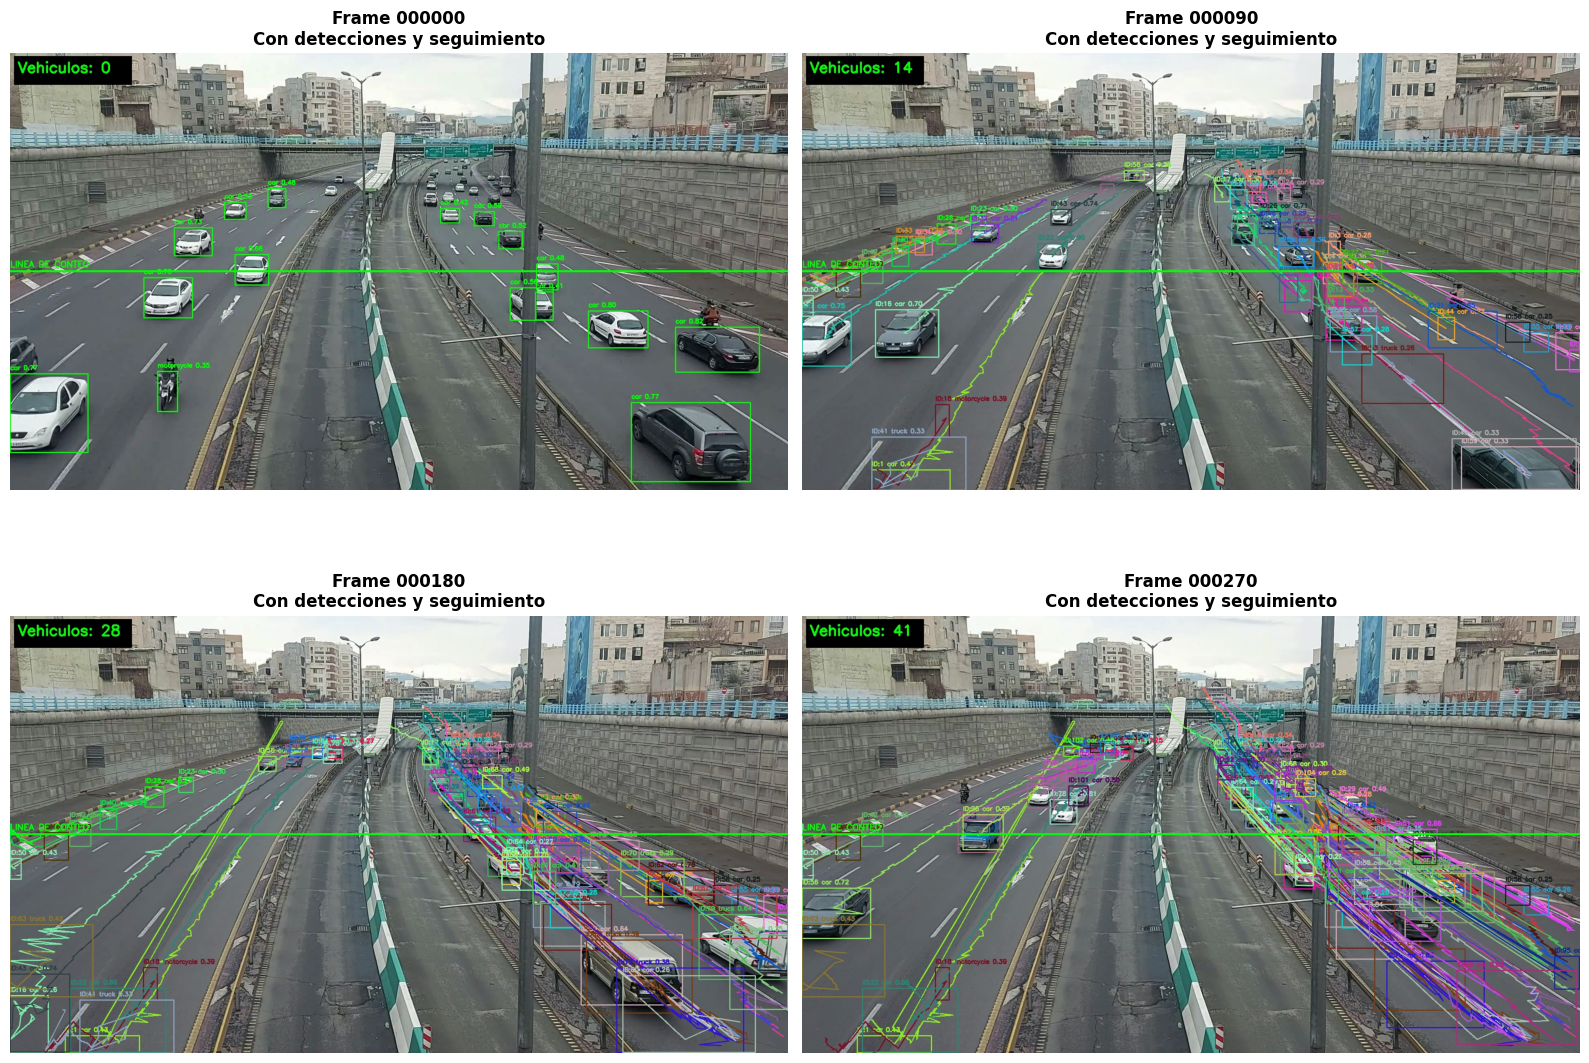

✅ Se muestran 4 frames de ejemplo
   Total de frames guardados: 10
   Imagen guardada en: ../results/ejemplos_frames_procesados.png


In [51]:
# Mostrar ejemplos de frames procesados si existen
print("🖼️  Ejemplos de Frames Procesados")
print("=" * 60)

frame_files = sorted(list(RESULTS_DIR.glob('frame_*.jpg')))
if frame_files:
    # Seleccionar algunos frames representativos
    num_samples = min(4, len(frame_files))
    indices = np.linspace(0, len(frame_files)-1, num_samples, dtype=int)
    sample_frames = [frame_files[i] for i in indices]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, frame_path in enumerate(sample_frames):
        frame_img = cv2.imread(str(frame_path))
        if frame_img is not None:
            frame_rgb = cv2.cvtColor(frame_img, cv2.COLOR_BGR2RGB)
            axes[idx].imshow(frame_rgb)
            
            # Extraer número de frame del nombre
            frame_num = frame_path.stem.split('_')[1]
            axes[idx].set_title(f'Frame {frame_num}\nCon detecciones y seguimiento', 
                               fontsize=12, fontweight='bold')
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'ejemplos_frames_procesados.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Se muestran {num_samples} frames de ejemplo")
    print(f"   Total de frames guardados: {len(frame_files)}")
    print(f"   Imagen guardada en: {RESULTS_DIR / 'ejemplos_frames_procesados.png'}")
else:
    print("⚠️  No se encontraron frames procesados. Ejecuta el pipeline con save_frames=True")


📊 RESULTADOS DEL PROCESAMIENTO

🎯 Estadísticas de Rendimiento:
   • Frames procesados: 300
   • Detecciones totales: 4274
   • Promedio de detecciones por frame: 14.25
   • Objetos únicos seguidos: 114
   • Vehículos contados (cruzaron línea): 45

⏱️  Rendimiento del Sistema:
   • Tiempo promedio por frame: 245.46 ms
   • FPS de procesamiento: 4.07
   • Tiempo total estimado: 73.64 segundos

⚙️  Configuración Utilizada:
   • Umbral de confianza: 0.25
   • Umbral IoU: 0.45
   • Clases de vehículos: [2, 3, 5, 7]

📈 Métricas de Eficiencia:
   • Tasa de detección: 14.25 detecciones/frame
   • Eficiencia de seguimiento: 2.7% (objetos seguidos/detecciones)
   • Tasa de conteo: 9.00 vehículos/minuto


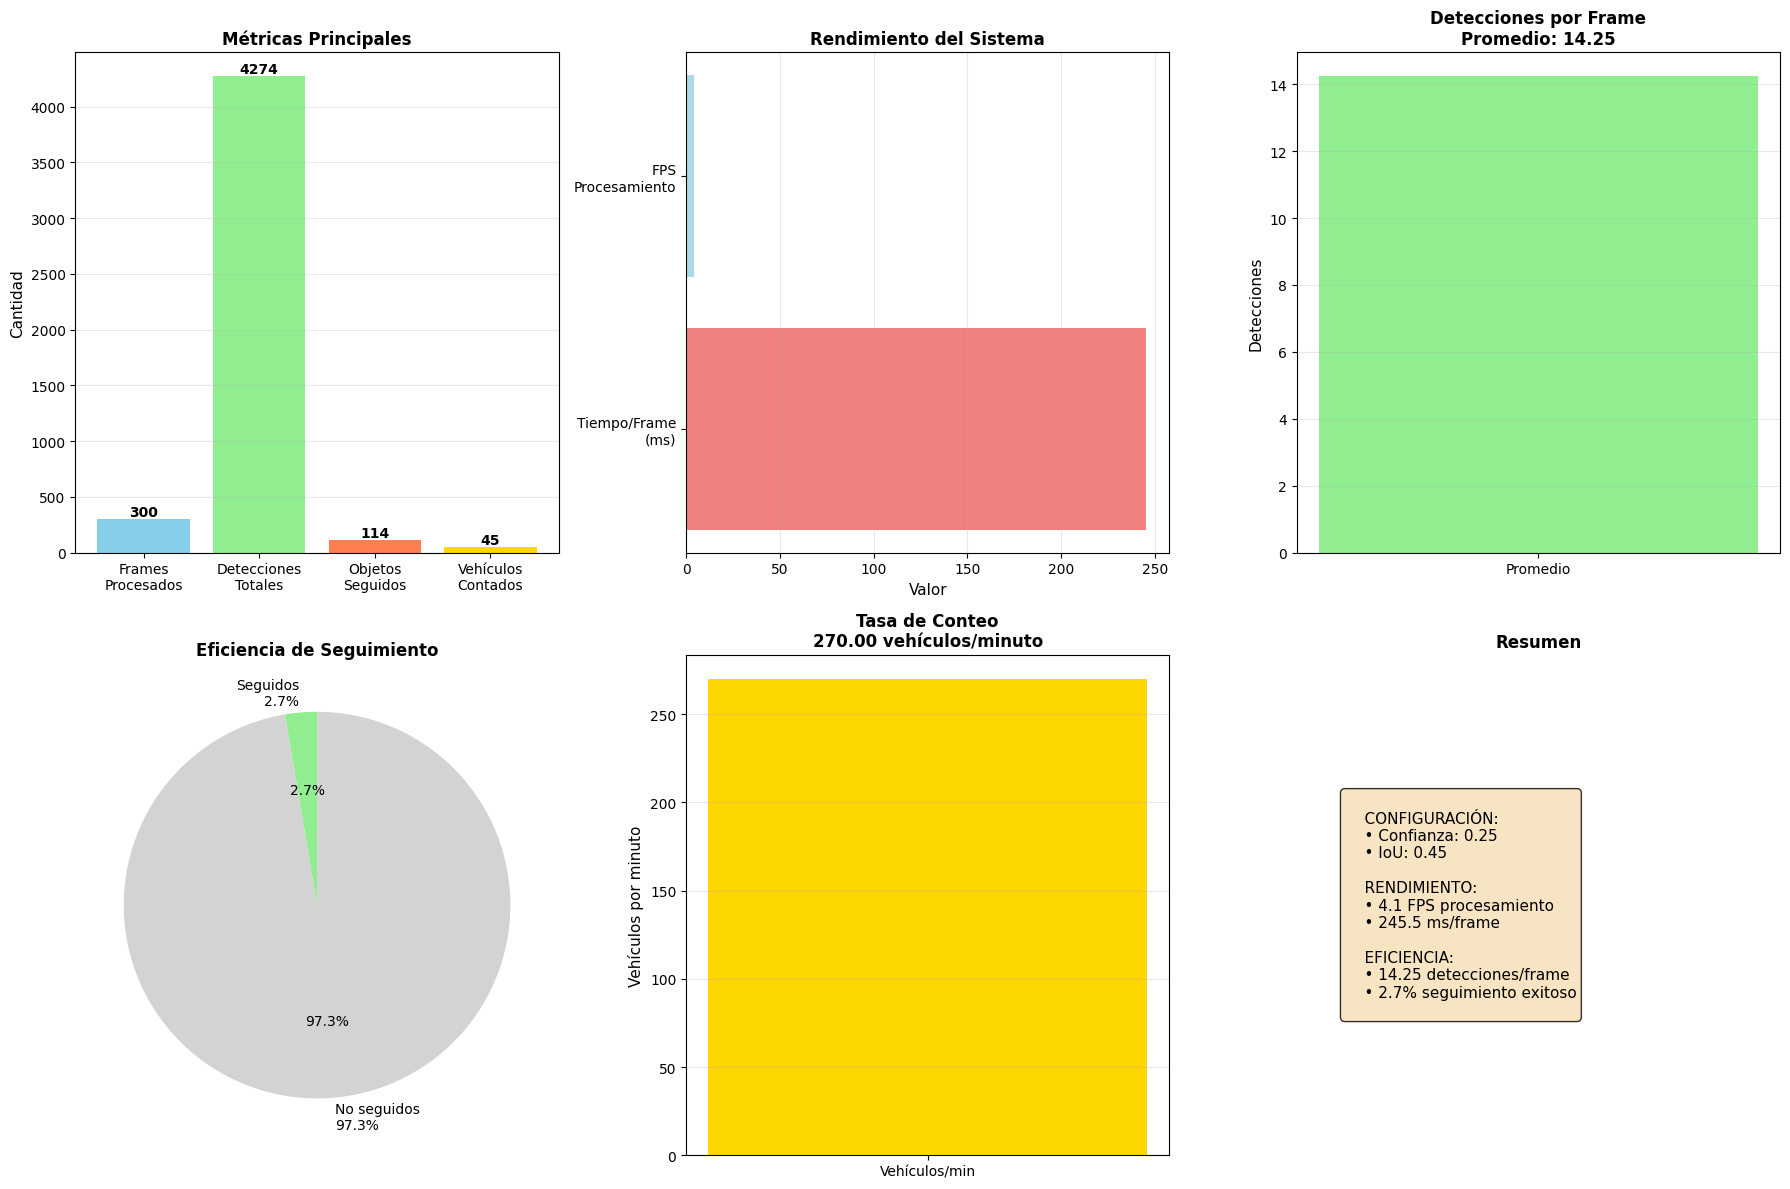


✅ Análisis completo guardado en: ../results/analisis_resultados.png


In [52]:
# Cargar y mostrar estadísticas si existen
stats_file = RESULTS_DIR / 'estadisticas.json'
if stats_file.exists():
    with open(stats_file, 'r') as f:
        results = json.load(f)
    
    stats = results['stats']
    config = results['tracker_config']
    
    print("=" * 60)
    print("📊 RESULTADOS DEL PROCESAMIENTO")
    print("=" * 60)
    
    print("\n🎯 Estadísticas de Rendimiento:")
    print(f"   • Frames procesados: {stats['frames_processed']}")
    print(f"   • Detecciones totales: {stats['total_detections']}")
    print(f"   • Promedio de detecciones por frame: {stats['total_detections']/stats['frames_processed']:.2f}")
    print(f"   • Objetos únicos seguidos: {stats['total_objects_tracked']}")
    print(f"   • Vehículos contados (cruzaron línea): {stats['final_vehicle_count']}")
    
    print("\n⏱️  Rendimiento del Sistema:")
    print(f"   • Tiempo promedio por frame: {stats['avg_processing_time']*1000:.2f} ms")
    print(f"   • FPS de procesamiento: {stats['fps_processing']:.2f}")
    print(f"   • Tiempo total estimado: {stats['frames_processed'] * stats['avg_processing_time']:.2f} segundos")
    
    print("\n⚙️  Configuración Utilizada:")
    print(f"   • Umbral de confianza: {config['conf_threshold']}")
    print(f"   • Umbral IoU: {config['iou_threshold']}")
    print(f"   • Clases de vehículos: {config['vehicle_classes']}")
    
    # Calcular eficiencia
    detection_rate = stats['total_detections'] / stats['frames_processed']
    tracking_efficiency = stats['total_objects_tracked'] / stats['total_detections'] if stats['total_detections'] > 0 else 0
    counting_rate = stats['final_vehicle_count'] / stats['frames_processed'] * 60  # por minuto
    
    print("\n📈 Métricas de Eficiencia:")
    print(f"   • Tasa de detección: {detection_rate:.2f} detecciones/frame")
    print(f"   • Eficiencia de seguimiento: {tracking_efficiency*100:.1f}% (objetos seguidos/detecciones)")
    print(f"   • Tasa de conteo: {counting_rate:.2f} vehículos/minuto")
    
    # Visualización mejorada de estadísticas
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Gráfica de barras de métricas principales
    metrics = ['Frames\nProcesados', 'Detecciones\nTotales', 'Objetos\nSeguidos', 'Vehículos\nContados']
    values = [stats['frames_processed'], stats['total_detections'], 
             stats['total_objects_tracked'], stats['final_vehicle_count']]
    axes[0, 0].bar(metrics, values, color=['skyblue', 'lightgreen', 'coral', 'gold'])
    axes[0, 0].set_title('Métricas Principales', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Cantidad', fontsize=11)
    for i, v in enumerate(values):
        axes[0, 0].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # 2. Rendimiento temporal
    axes[0, 1].barh(['Tiempo/Frame\n(ms)', 'FPS\nProcesamiento'], 
                   [stats['avg_processing_time']*1000, stats['fps_processing']],
                   color=['lightcoral', 'lightblue'])
    axes[0, 1].set_title('Rendimiento del Sistema', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Valor', fontsize=11)
    axes[0, 1].grid(True, alpha=0.3, axis='x')
    
    # 3. Distribución de detecciones por frame
    detections_per_frame = stats['total_detections'] / stats['frames_processed']
    axes[0, 2].bar(['Promedio'], [detections_per_frame], color='lightgreen')
    axes[0, 2].set_title(f'Detecciones por Frame\nPromedio: {detections_per_frame:.2f}', 
                        fontsize=12, fontweight='bold')
    axes[0, 2].set_ylabel('Detecciones', fontsize=11)
    axes[0, 2].grid(True, alpha=0.3, axis='y')
    
    # 4. Eficiencia de seguimiento
    tracking_eff = (stats['total_objects_tracked'] / stats['total_detections'] * 100) if stats['total_detections'] > 0 else 0
    axes[1, 0].pie([tracking_eff, 100-tracking_eff], 
                  labels=[f'Seguidos\n{tracking_eff:.1f}%', f'No seguidos\n{100-tracking_eff:.1f}%'],
                  autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightgray'])
    axes[1, 0].set_title('Eficiencia de Seguimiento', fontsize=12, fontweight='bold')
    
    # 5. Tasa de conteo
    counting_rate_per_min = stats['final_vehicle_count'] / (stats['frames_processed'] / 30) * 60 if stats['frames_processed'] > 0 else 0
    axes[1, 1].bar(['Vehículos/min'], [counting_rate_per_min], color='gold')
    axes[1, 1].set_title(f'Tasa de Conteo\n{counting_rate_per_min:.2f} vehículos/minuto', 
                         fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Vehículos por minuto', fontsize=11)
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    # 6. Resumen textual
    summary_text = f"""
    CONFIGURACIÓN:
    • Confianza: {config['conf_threshold']}
    • IoU: {config['iou_threshold']}
    
    RENDIMIENTO:
    • {stats['fps_processing']:.1f} FPS procesamiento
    • {stats['avg_processing_time']*1000:.1f} ms/frame
    
    EFICIENCIA:
    • {detection_rate:.2f} detecciones/frame
    • {tracking_eff:.1f}% seguimiento exitoso
    """
    axes[1, 2].text(0.1, 0.5, summary_text, fontsize=11,
                   verticalalignment='center',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    axes[1, 2].axis('off')
    axes[1, 2].set_title('Resumen', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'analisis_resultados.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✅ Análisis completo guardado en: {RESULTS_DIR / 'analisis_resultados.png'}")
else:
    print("⚠️  No se encontraron estadísticas. Ejecuta primero el procesamiento del video.")


In [53]:
def set_count_line(self, line_coords):
    """
    Define la línea virtual para conteo de vehículos
    
    Args:
        line_coords: Tupla (x1, y1, x2, y2) definiendo la línea
    """
    self.count_line = line_coords
    print(f"✅ Línea de conteo establecida: {line_coords}")

def check_line_crossing(self, point1, point2, line):
    """
    Verifica si un segmento cruza la línea virtual
    
    Args:
        point1: Punto anterior (x, y)
        point2: Punto actual (x, y)
        line: Línea virtual (x1, y1, x2, y2)
    
    Returns:
        bool: True si cruza la línea
    """
    x1, y1, x2, y2 = line
    px1, py1 = point1
    px2, py2 = point2
    
    # Ecuación de la línea: ax + by + c = 0
    a = y2 - y1
    b = x1 - x2
    c = x2 * y1 - x1 * y2
    
    # Evaluar puntos en la ecuación
    d1 = a * px1 + b * py1 + c
    d2 = a * px2 + b * py2 + c
    
    # Si tienen signos diferentes, cruza la línea
    if d1 * d2 < 0:
        # Verificar que el cruce está dentro del segmento de la línea
        # Calcular intersección
        denom = (px2 - px1) * (y2 - y1) - (py2 - py1) * (x2 - x1)
        if abs(denom) > 1e-6:
            t = ((x1 - px1) * (y2 - y1) - (y1 - py1) * (x2 - x1)) / denom
            if 0 <= t <= 1:
                return True
    return False

def update_vehicle_count(self, frame_annotated):
    """
    Actualiza el conteo de vehículos que cruzan la línea virtual
    
    Args:
        frame_annotated: Frame anotado donde dibujar la línea y contador
    """
    if self.count_line is None:
        return frame_annotated
    
    x1, y1, x2, y2 = self.count_line
    
    # Dibujar línea virtual
    cv2.line(frame_annotated, (x1, y1), (x2, y2), (0, 255, 0), 3)
    cv2.putText(frame_annotated, "LINEA DE CONTEO", (x1, y1 - 10),
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    
    # Verificar cruces
    for obj_id, tracked_obj in self.tracked_objects.items():
        if tracked_obj.crossed_line or len(tracked_obj.trajectory) < 2:
            continue
        
        # Verificar si cruza la línea
        if self.check_line_crossing(
            tracked_obj.trajectory[-2],
            tracked_obj.trajectory[-1],
            self.count_line
        ):
            tracked_obj.crossed_line = True
            self.vehicle_count += 1
            print(f"🚗 Vehículo {obj_id} cruzó la línea. Total: {self.vehicle_count}")
    
    # Dibujar contador
    cv2.rectangle(frame_annotated, (10, 10), (300, 80), (0, 0, 0), -1)
    cv2.putText(frame_annotated, f"Vehiculos: {self.vehicle_count}", (20, 50),
               cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)
    
    self.count_history.append(self.vehicle_count)
    
    return frame_annotated

VehicleTracker.set_count_line = set_count_line
VehicleTracker.check_line_crossing = check_line_crossing
VehicleTracker.update_vehicle_count = update_vehicle_count

print("✅ Métodos de conteo implementados")


✅ Métodos de conteo implementados


### 📁 Archivos y Resultados Generados

Todos los resultados del procesamiento se guardan en la carpeta `results/`:

#### Videos y Frames
- **`video_procesado.mp4`**: Video completo con todas las anotaciones (detecciones, trayectorias, línea de conteo)
- **`frame_*.jpg`**: Frames individuales guardados cada 30 frames para análisis detallado

#### Estadísticas y Datos
- **`estadisticas.json`**: Archivo JSON con todas las métricas numéricas del procesamiento
- **`estadisticas_procesamiento.png`**: Gráficas de evaluación del rendimiento

#### Visualizaciones Explicativas
- **`ejemplo_deteccion.png`**: Esquema de bounding box y centro
- **`ejemplo_deteccion_yolo.png`**: Ejemplo real de detección YOLO
- **`explicacion_iou.png`**: Visualización del concepto IoU
- **`explicacion_linea_virtual.png`**: Ejemplos de cruce de línea
- **`diagrama_pipeline.png`**: Diagrama de flujo del sistema
- **`video_info.png`**: Información del video de entrada
- **`analisis_resultados.png`**: Análisis completo de resultados
- **`ejemplos_frames_procesados.png`**: Muestra de frames procesados


In [54]:
# Listar todos los archivos generados
print("📁 Resumen de Archivos Generados")
print("=" * 60)

result_files = sorted(list(RESULTS_DIR.glob('*')))
if result_files:
    print(f"\nTotal de archivos en results/: {len(result_files)}\n")
    
    categories = {
        'Videos': ['.mp4'],
        'Imágenes': ['.png', '.jpg', '.jpeg'],
        'Datos': ['.json', '.csv'],
        'Otros': []
    }
    
    for category, extensions in categories.items():
        files_in_category = [f for f in result_files 
                           if f.suffix.lower() in extensions or (not extensions and 
                           f.suffix.lower() not in [ext for exts in categories.values() for ext in exts])]
        if files_in_category:
            print(f"📂 {category}:")
            for f in files_in_category:
                size_mb = f.stat().st_size / (1024 * 1024)
                print(f"   • {f.name} ({size_mb:.2f} MB)")
            print()
    
    total_size = sum(f.stat().st_size for f in result_files) / (1024 * 1024)
    print(f"💾 Tamaño total: {total_size:.2f} MB")
else:
    print("⚠️  No se encontraron archivos en results/")


📁 Resumen de Archivos Generados

Total de archivos en results/: 21

📂 Videos:
   • video_procesado.mp4 (48.54 MB)

📂 Imágenes:
   • analisis_resultados.png (0.17 MB)
   • diagrama_pipeline.png (0.07 MB)
   • ejemplo_deteccion.png (0.04 MB)
   • ejemplo_deteccion_yolo.png (1.11 MB)
   • ejemplos_frames_procesados.png (4.80 MB)
   • estadisticas_procesamiento.png (0.13 MB)
   • explicacion_iou.png (0.10 MB)
   • explicacion_linea_virtual.png (0.08 MB)
   • frame_000000.jpg (0.60 MB)
   • frame_000030.jpg (0.73 MB)
   • frame_000060.jpg (0.72 MB)
   • frame_000090.jpg (0.75 MB)
   • frame_000120.jpg (0.79 MB)
   • frame_000150.jpg (0.83 MB)
   • frame_000180.jpg (0.86 MB)
   • frame_000210.jpg (0.85 MB)
   • frame_000240.jpg (0.86 MB)
   • frame_000270.jpg (0.87 MB)
   • video_info.png (1.86 MB)

📂 Datos:
   • estadisticas.json (0.00 MB)

💾 Tamaño total: 64.77 MB


## 5. Pipeline Principal de Procesamiento de Video

In [56]:
def process_video(self, video_path, output_path=None, count_line=None, 
                  max_frames=None, save_frames=False):
    """
    Procesa un video completo con detección y seguimiento
    
    Args:
        video_path: Ruta al video de entrada
        output_path: Ruta para guardar el video procesado
        count_line: Coordenadas de la línea de conteo (x1, y1, x2, y2)
        max_frames: Número máximo de frames a procesar (None para todos)
        save_frames: Si True, guarda frames individuales
    
    Returns:
        dict: Estadísticas del procesamiento
    """
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise ValueError(f"No se pudo abrir el video: {video_path}")
    
    # Obtener propiedades del video
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"📹 Video: {width}x{height} @ {fps} FPS, {total_frames} frames")
    
    # Configurar línea de conteo si se proporciona
    if count_line:
        self.set_count_line(count_line)
    elif count_line is None and width > 0:
        # Línea por defecto: horizontal en el centro
        default_line = (0, height // 2, width, height // 2)
        self.set_count_line(default_line)
    
    # Configurar video de salida
    writer = None
    if output_path:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        writer = cv2.VideoWriter(str(output_path), fourcc, fps, (width, height))
    
    # Variables de seguimiento
    prev_frame = None
    prev_gray = None
    frame_number = 0
    stats = {
        'total_detections': 0,
        'total_objects_tracked': 0,
        'frames_processed': 0,
        'processing_times': []
    }
    
    frames_to_save = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        if max_frames and frame_number >= max_frames:
            break
        
        start_time = time.time()
        
        # Convertir a escala de grises para flujo óptico
        curr_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Detectar vehículos
        detections = self.detect_vehicles(frame)
        stats['total_detections'] += len(detections)
        
        # Seguimiento con flujo óptico
        if prev_frame is not None and prev_gray is not None:
            frame_annotated = self.track_with_optical_flow(
                prev_frame, frame, prev_gray, curr_gray, detections, frame_number
            )
        else:
            # Primer frame: solo detecciones
            frame_annotated = frame.copy()
            for detection in detections:
                x1, y1, x2, y2 = detection.bbox
                cv2.rectangle(frame_annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
                label = f"{detection.class_name} {detection.confidence:.2f}"
                cv2.putText(frame_annotated, label, (x1, y1 - 10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        # Actualizar conteo
        frame_annotated = self.update_vehicle_count(frame_annotated)
        
        # Guardar frame si se solicita
        if save_frames and frame_number % 30 == 0:  # Cada 30 frames
            frames_to_save.append((frame_number, frame_annotated.copy()))
        
        # Escribir frame al video de salida
        if writer:
            writer.write(frame_annotated)
        
        # Actualizar para siguiente iteración
        prev_frame = frame.copy()
        prev_gray = curr_gray.copy()
        frame_number += 1
        stats['frames_processed'] = frame_number
        
        processing_time = time.time() - start_time
        stats['processing_times'].append(processing_time)
        
        if frame_number % 30 == 0:
            print(f"Procesado frame {frame_number}/{total_frames} "
                  f"({frame_number/total_frames*100:.1f}%) - "
                  f"Vehículos: {self.vehicle_count}")
    
    cap.release()
    if writer:
        writer.release()
    
    stats['total_objects_tracked'] = self.next_id
    stats['final_vehicle_count'] = self.vehicle_count
    stats['avg_processing_time'] = np.mean(stats['processing_times'])
    stats['fps_processing'] = 1.0 / stats['avg_processing_time'] if stats['avg_processing_time'] > 0 else 0
    
    # Guardar frames si se solicita
    if save_frames and frames_to_save:
        for frame_num, frame_img in frames_to_save:
            frame_path = RESULTS_DIR / f"frame_{frame_num:06d}.jpg"
            cv2.imwrite(str(frame_path), frame_img)
    
    print(f"\n✅ Procesamiento completado:")
    print(f"   Frames procesados: {stats['frames_processed']}")
    print(f"   Vehículos detectados: {stats['total_detections']}")
    print(f"   Objetos seguidos: {stats['total_objects_tracked']}")
    print(f"   Vehículos contados: {stats['final_vehicle_count']}")
    print(f"   Tiempo promedio por frame: {stats['avg_processing_time']:.3f}s")
    print(f"   FPS de procesamiento: {stats['fps_processing']:.2f}")
    
    return stats

VehicleTracker.process_video = process_video

print("✅ Pipeline principal de procesamiento implementado")


✅ Pipeline principal de procesamiento implementado


## 6. Funciones de Visualización y Evaluación

In [58]:
def plot_processing_stats(stats, save_path=None):
    """Visualiza estadísticas del procesamiento"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Tiempos de procesamiento
    axes[0, 0].plot(stats['processing_times'], alpha=0.7)
    axes[0, 0].axhline(stats['avg_processing_time'], color='r', linestyle='--', 
                      label=f'Promedio: {stats["avg_processing_time"]:.3f}s')
    axes[0, 0].set_title('Tiempo de Procesamiento por Frame', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Frame')
    axes[0, 0].set_ylabel('Tiempo (s)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Histograma de tiempos
    axes[0, 1].hist(stats['processing_times'], bins=50, edgecolor='black', alpha=0.7)
    axes[0, 1].axvline(stats['avg_processing_time'], color='r', linestyle='--',
                      label=f'Promedio: {stats["avg_processing_time"]:.3f}s')
    axes[0, 1].set_title('Distribución de Tiempos de Procesamiento', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Tiempo (s)')
    axes[0, 1].set_ylabel('Frecuencia')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Estadísticas generales
    stats_text = f"""
    Frames Procesados: {stats['frames_processed']}
    Detecciones Totales: {stats['total_detections']}
    Objetos Seguidos: {stats['total_objects_tracked']}
    Vehículos Contados: {stats['final_vehicle_count']}
    FPS Procesamiento: {stats['fps_processing']:.2f}
    """
    axes[1, 0].text(0.1, 0.5, stats_text, fontsize=12, verticalalignment='center',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    axes[1, 0].axis('off')
    axes[1, 0].set_title('Estadísticas Generales', fontsize=12, fontweight='bold')
    
    # Conteo de vehículos a lo largo del tiempo
    if hasattr(stats, 'count_history') and stats.get('count_history'):
        axes[1, 1].plot(stats['count_history'], linewidth=2, color='green')
        axes[1, 1].set_title('Conteo de Vehículos en el Tiempo', fontsize=12, fontweight='bold')
        axes[1, 1].set_xlabel('Frame')
        axes[1, 1].set_ylabel('Vehículos Contados')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'No hay datos de conteo', 
                       ha='center', va='center', fontsize=12)
        axes[1, 1].axis('off')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

def save_results(stats, tracker, output_path):
    """Guarda resultados en formato JSON"""
    results = {
        'stats': {
            'frames_processed': stats['frames_processed'],
            'total_detections': stats['total_detections'],
            'total_objects_tracked': stats['total_objects_tracked'],
            'final_vehicle_count': stats['final_vehicle_count'],
            'avg_processing_time': float(stats['avg_processing_time']),
            'fps_processing': float(stats['fps_processing'])
        },
        'tracker_config': {
            'conf_threshold': tracker.conf_threshold,
            'iou_threshold': tracker.iou_threshold,
            'vehicle_classes': tracker.vehicle_classes
        }
    }
    
    with open(output_path, 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"✅ Resultados guardados en {output_path}")

print("✅ Funciones de visualización y evaluación implementadas")


✅ Funciones de visualización y evaluación implementadas


## 7. Ejecución del Pipeline Completo

🚀 Inicializando sistema de detección y seguimiento...
✅ Tracker inicializado con modelo: yolov8n.pt
✅ Encontrados 2 video(s):
   - SampleVideo_LowQuality.mp4
   - Sample_Video_HighQuality.mp4

📹 Procesando video: SampleVideo_LowQuality.mp4
📹 Video: 1920x1080 @ 24 FPS, 1001 frames
✅ Línea de conteo establecida: (0, 540, 1920, 540)
🚗 Vehículo 10 cruzó la línea. Total: 1
Procesado frame 30/1001 (3.0%) - Vehículos: 1
🚗 Vehículo 4 cruzó la línea. Total: 2
🚗 Vehículo 27 cruzó la línea. Total: 3
🚗 Vehículo 39 cruzó la línea. Total: 4
🚗 Vehículo 35 cruzó la línea. Total: 5
🚗 Vehículo 42 cruzó la línea. Total: 6
🚗 Vehículo 40 cruzó la línea. Total: 7
🚗 Vehículo 34 cruzó la línea. Total: 8
🚗 Vehículo 28 cruzó la línea. Total: 9
🚗 Vehículo 23 cruzó la línea. Total: 10
🚗 Vehículo 33 cruzó la línea. Total: 11
Procesado frame 60/1001 (6.0%) - Vehículos: 11
🚗 Vehículo 29 cruzó la línea. Total: 12
🚗 Vehículo 31 cruzó la línea. Total: 13
🚗 Vehículo 2 cruzó la línea. Total: 14
Procesado frame 90/1001 (9

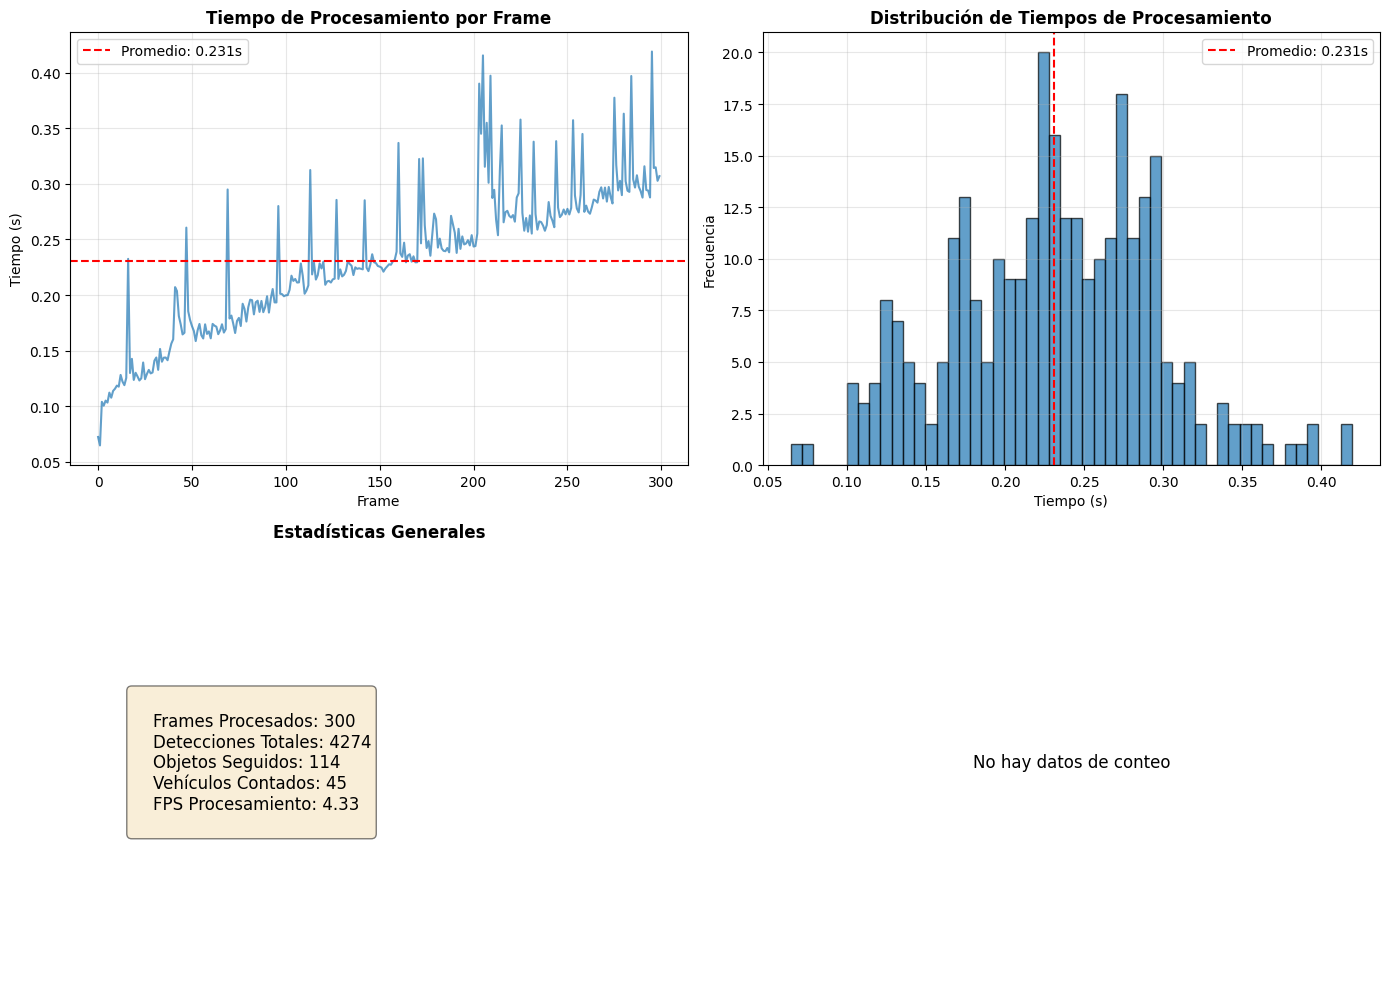


✅ Procesamiento completado!
   Video de salida: ../results/video_procesado.mp4
   Estadísticas: ../results/estadisticas.json


In [59]:
# Inicializar el tracker
print("🚀 Inicializando sistema de detección y seguimiento...")
tracker = VehicleTracker(yolo_model='yolov8n.pt', conf_threshold=0.25)

# Buscar videos disponibles
video_files = list(DATA_DIR.glob('*.mp4'))
if not video_files:
    print("⚠️  No se encontraron archivos de video en data/")
    print("   Asegúrate de tener videos en formato .mp4")
else:
    print(f"✅ Encontrados {len(video_files)} video(s):")
    for vf in video_files:
        print(f"   - {vf.name}")

# Seleccionar video (usar el primero disponible o el de menor calidad para pruebas rápidas)
if video_files:
    # Preferir video de baja calidad para pruebas más rápidas
    low_quality = DATA_DIR / 'SampleVideo_LowQuality.mp4'
    video_path = low_quality if low_quality.exists() else video_files[0]
    
    print(f"\n📹 Procesando video: {video_path.name}")
    
    # Procesar video (limitar a 300 frames para prueba inicial)
    output_video = RESULTS_DIR / 'video_procesado.mp4'
    output_stats = RESULTS_DIR / 'estadisticas.json'
    
    # Agregar count_history a stats
    stats = tracker.process_video(
        video_path=video_path,
        output_path=output_video,
        count_line=None,  # Se establecerá automáticamente en el centro
        max_frames=300,  # Limitar para prueba inicial (None para procesar todo)
        save_frames=True  # Guardar frames cada 30 frames
    )
    
    # Agregar count_history a stats
    stats['count_history'] = tracker.count_history
    
    # Guardar estadísticas
    save_results(stats, tracker, output_stats)
    
    # Visualizar estadísticas
    plot_processing_stats(stats, save_path=RESULTS_DIR / 'estadisticas_procesamiento.png')
    
    print(f"\n✅ Procesamiento completado!")
    print(f"   Video de salida: {output_video}")
    print(f"   Estadísticas: {output_stats}")
else:
    print("\n⚠️  No hay videos para procesar. Por favor, coloca videos .mp4 en la carpeta data/")

## 8. Resumen y Conclusiones

### Características Implementadas:

1. **Detección de Objetos con YOLO v8**
   - Modelo pre-entrenado en COCO dataset
   - Detección de vehículos (carros, motocicletas, autobuses, camiones)
   - Filtrado por umbral de confianza

2. **Seguimiento con Flujo Óptico Lucas-Kanade**
   - Seguimiento de puntos clave entre frames
   - Asociación de detecciones usando IoU
   - Mantenimiento de identidad de objetos

3. **Conteo de Vehículos**
   - Línea virtual para detección de cruces
   - Conteo automático de vehículos que cruzan la línea
   - Visualización en tiempo real

4. **Evaluación Cuantitativa**
   - Métricas de rendimiento (FPS, tiempo de procesamiento)
   - Estadísticas de detección y seguimiento
   - Visualizaciones de resultados

### Resultados Guardados:

- **Video procesado**: `results/video_procesado.mp4`
- **Frames individuales**: `results/frame_*.jpg`
- **Estadísticas**: `results/estadisticas.json`
- **Gráficas**: `results/estadisticas_procesamiento.png`

---

## 📚 Referencias y Recursos

- **YOLO v8**: https://github.com/ultralytics/ultralytics
- **OpenCV Optical Flow**: https://docs.opencv.org/4.x/d4/dee/tutorial_optical_flow.html
- **Lucas-Kanade Method**: Método clásico de flujo óptico para seguimiento de objetos

---

**Desarrollado para el Trabajo 4: Detección y Seguimiento de Objetos con YOLO y Flujo Óptico**
